In [ ]:
# Mount drive
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['dog-breed-identification.py',
 'train',
 'MVP-dog-breeds.ipynb',
 'dog-breed-identification',
 'CNN-dog-breeds.ipynb',
 'Prototype-CNN-dog-breeds.ipynb',
 'Untitled0.ipynb',
 'Copy of Copy of Prototype-CNN-dog-breeds.ipynb',
 'ResNet-Prototype-CNN-dog-breeds.ipynb',
 'model_12_breed',
 'Untitled1.ipynb',
 'ResNet-Prototype-with-Augmentation-CNN-dog-breeds.ipynb',
 'Copy of ResNet-Prototype-with-Augmentation-CNN-dog-breeds.ipynb']

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras.applications.resnet_v2 import ResNet50V2,preprocess_input
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
# Create df of train labels
def append_ext(fn):
  return fn+".jpg"

all_df = pd.read_csv("dog-breed-identification/labels.csv", dtype=str)

all_df['id'] = all_df['id'].apply(append_ext)
all_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


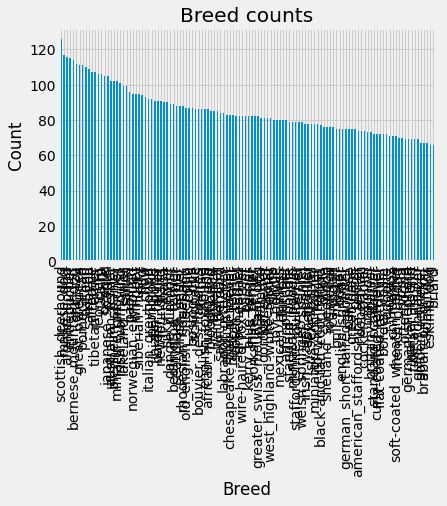

In [ ]:
# Check all labels balancing
all_df.breed.value_counts().plot(kind='bar')
plt.title('Breed counts')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.show()

In [ ]:
# Number of images per breed
df_agg = all_df['breed'].value_counts().to_frame().reset_index()
df_agg.rename(columns={'index':'breed', 'breed':'count'}, inplace=True)
df_agg.sort_values(by='count', ascending=False, inplace=True)
df_agg.head()

# Reduce data to select number of breeds, randomly
num_breeds = 30
breeds_select = list(df_agg['breed'].sample(n=num_breeds, random_state=29))
print(breeds_select)

all_df = all_df[all_df['breed'].isin(breeds_select)]
print(all_df.shape)
all_df.head()

['blenheim_spaniel', 'lakeland_terrier', 'miniature_pinscher', 'norwegian_elkhound', 'chow', 'entlebucher', 'airedale', 'whippet', 'cairn', 'pomeranian', 'pug', 'japanese_spaniel', 'siberian_husky', 'great_pyrenees', 'beagle', 'bernese_mountain_dog', 'shih-tzu', 'tibetan_terrier', 'papillon', 'maltese_dog', 'italian_greyhound', 'pembroke', 'australian_terrier', 'samoyed', 'scottish_deerhound', 'basenji', 'afghan_hound', 'leonberg', 'irish_wolfhound', 'saluki']
(3134, 2)


,id,breed
8,003df8b8a8b05244b1d920bb6cf451f9.jpg,basenji
9,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec.jpg,maltese_dog
18,007ff9a78eba2aebb558afea3a51c469.jpg,lakeland_terrier
29,00bee065dcec471f26394855c5c2f3de.jpg,cairn


In [ ]:
# Split and Balance Data (strategy adopted from https://www.kaggle.com/code/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe/notebook)
# split data before balancing labels
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(all_df, random_state=24)
# number of samples per category
ncat_bal = train_df['breed'].value_counts().max()
train_df = train_df.groupby('breed', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True, random_state=24)).reset_index(drop=True)

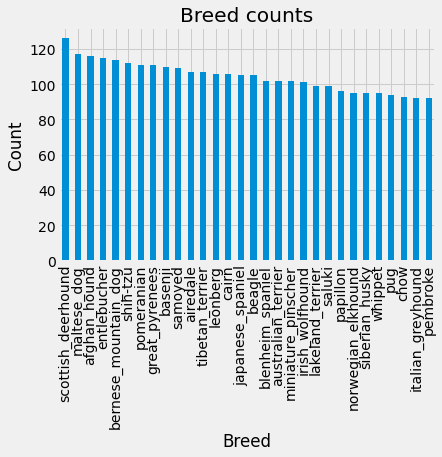

In [ ]:
# Check breed labels balancing
all_df.breed.value_counts().plot(kind='bar')
plt.title('Breed counts')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.show()

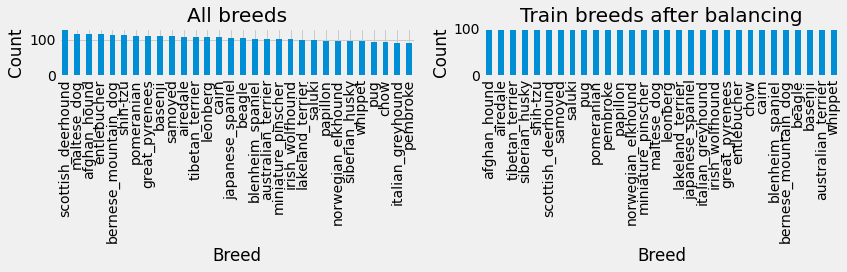

In [ ]:
# Plot samples per category before and after balancing
f, axs = plt.subplots(1,2,figsize=(12,4))
# Before balancing
all_df.breed.value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('All breeds')
axs[0].set_xlabel('Breed')
axs[0].set_ylabel('Count')
# After balancing
train_df.breed.value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Train breeds after balancing')
axs[1].set_xlabel('Breed')
axs[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# Check train and test dimensions
print("train shape: ", train_df.shape)
print("test shape: ", test_df.shape)

train shape:  (2880, 2)
test shape:  (784, 2)


In [ ]:
# Split train data into train and validation 
new_train_df, val_df = (train_test_split(train_df, test_size=.25, random_state=24))

# Check new train and validation dimensions
print("train shape: ", new_train_df.shape)
print("val shape: ", val_df.shape)

train shape:  (2160, 2)
val shape:  (720, 2)


In [ ]:
# Flow from Dataframe with Image Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
      dataframe=new_train_df,
      directory="dog-breed-identification/train/",
      x_col="id",
      y_col="breed",
      seed=42,
      shuffle=True,
      # All images will be resized to 150x150
      target_size=(150, 150),
      batch_size=20,
      # Since we use categorical_crossentropy loss, we need categorical labels
      class_mode="categorical")

validation_generator = test_datagen.flow_from_dataframe(
      dataframe=val_df,
      directory="dog-breed-identification/train/",
      x_col="id",
      y_col="breed",
      seed=42,
      shuffle=True,
      target_size=(150, 150),
      batch_size=20,
      class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(
      dataframe=test_df,
      directory="dog-breed-identification/train/",
      x_col="id",
      y_col="breed",
      seed=42,
      shuffle=False,
      target_size=(150, 150),
      batch_size=20,
      class_mode="categorical")

Found 2160 validated image filenames belonging to 30 classes.
Found 720 validated image filenames belonging to 30 classes.
Found 784 validated image filenames belonging to 30 classes.


In [ ]:
# Number of images in train and val
train_count = 2160
val_count = 720
test_count = 784

In [ ]:
# Instantiate ResNet50 model
resnet = ResNet50V2(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [ ]:
#freeze all trainable layers and train only top layers
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
#add global average pooling layer and Batch Normalization layer
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
#add fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

In [ ]:
#add output layer having the shape equal to number of breeds
predictions = Dense(num_breeds, activation='softmax')(x)

In [ ]:
#create model class with inputs and outputs
from tensorflow.keras.models import load_model,Model
model = Model(inputs=resnet.input, outputs=predictions)

In [ ]:
#epochs for model training and learning rate for optimizer
epochs = 30
learning_rate = 1e-3

In [ ]:
#using RMSprop optimizer compile or build the model
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=20,
                    validation_data=validation_generator)

Epoch 1/30
108/108 [==============================] - 98s 913ms/step - loss: 1.5334 - accuracy: 0.5509 - val_loss: 0.8003 - val_accuracy: 0.7432
Epoch 2/30
108/108 [==============================] - 30s 279ms/step - loss: 1.3468 - accuracy: 0.6032 - val_loss: 0.7416 - val_accuracy: 0.7942
Epoch 3/30
108/108 [==============================] - 30s 276ms/step - loss: 1.2876 - accuracy: 0.6259 - val_loss: 0.6830 - val_accuracy: 0.7993
Epoch 4/30
108/108 [==============================] - 30s 278ms/step - loss: 1.2048 - accuracy: 0.6542 - val_loss: 0.7026 - val_accuracy: 0.8078
Epoch 5/30
108/108 [==============================] - 30s 274ms/step - loss: 1.2124 - accuracy: 0.6551 - val_loss: 0.6304 - val_accuracy: 0.8350
Epoch 6/30
108/108 [==============================] - 31s 284ms/step - loss: 1.0862 - accuracy: 0.6796 - val_loss: 0.6482 - val_accuracy: 0.8299
Epoch 7/30
108/108 [==============================] - 31s 284ms/step - loss: 1.0424 - accuracy: 0.7074 - val_loss: 0.6561 - val_ac

In [ ]:
# Save model
model.save("model_30_breed")

INFO:tensorflow:Assets written to: model_30_breed/assets


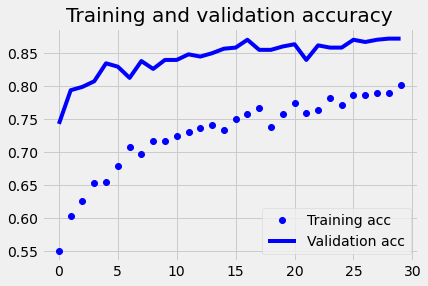

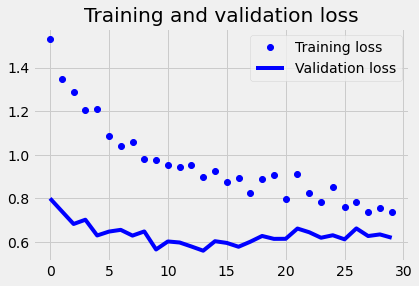

In [ ]:
# Plot loss and accurary curves during training
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluation
# Predict on test data
y_pred_raw = model.predict(test_generator)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = test_df.breed.values
y_true=y_true[:len(y_pred)] 

In [ ]:
# Get dictionary of breeds to map to predictions
label_map = (test_generator.class_indices)
inv_label_map = {value: key for key, value in label_map.items()}

In [ ]:
y_pred[:5]

array([18, 29, 13,  3,  8])

In [ ]:
range(len(y_pred)-1)
inv_label_map[0]

'afghan_hound'

In [ ]:
y_pred_names = []
for i in range(len(y_pred)):
  name = inv_label_map[y_pred[i]]
  y_pred_names.append(name)
y_pred_names[:5]

['norwegian_elkhound', 'whippet', 'japanese_spaniel', 'basenji', 'chow']

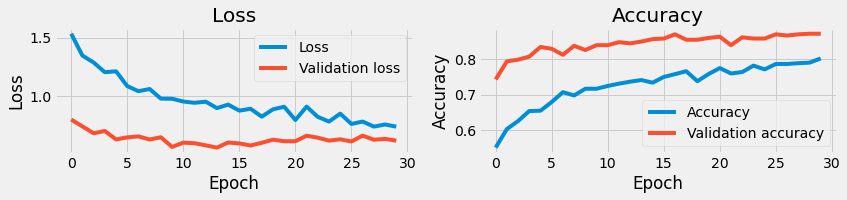

In [ ]:
# Plot training history
## Trained model analysis and evaluation
f, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(history.history['loss'], label="Loss")
ax[0].plot(history.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Accuracy
ax[1].plot(history.history['accuracy'], label="Accuracy")
ax[1].plot(history.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
#Print classification report
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred_names))

                      precision    recall  f1-score   support

        afghan_hound       0.74      0.81      0.78        32
            airedale       0.78      0.69      0.73        26
  australian_terrier       0.79      0.76      0.78        25
             basenji       0.60      0.76      0.67        33
              beagle       0.82      0.77      0.79        30
bernese_mountain_dog       0.96      0.86      0.91        28
    blenheim_spaniel       0.79      0.73      0.76        26
               cairn       0.80      0.77      0.78        26
                chow       0.80      0.89      0.84        27
         entlebucher       0.80      0.95      0.87        21
      great_pyrenees       0.61      0.65      0.63        26
     irish_wolfhound       0.38      0.29      0.32        21
   italian_greyhound       0.52      0.50      0.51        30
    japanese_spaniel       0.70      0.81      0.75        26
    lakeland_terrier       0.47      0.50      0.48        16
       

In [ ]:
# Predict on new image
#get the image of the dog for prediction
import cv2

pred_img_path = 'Ellie.jpg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((150,150)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))
 
#display the image of dog
cv2.imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((150,150)))) 
 
#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)

error: ignored

In [ ]:
img = cv2.imread("Ellie.jpg",0)
img = cv2.resize(img, (150, 150))
img = np.reshape(img, [1, 150, 150, 1])
print(np.argmax(model.predict(img)))

error: ignored